In [22]:
# i am importing numpy and pands for working with data
import numpy as np
import pandas as pd

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# for preprocessing
from pathlib import Path
from sklearn.model_selection import train_test_split

# i'll get my model up and running with tensorflow
import tensorflow as tf

# evaluating the performance using sklearn
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
# using flow from data frame
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [24]:
# creating the data frame
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [25]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(all_df)

                                                Filepath     Label
0      ../input/surface-crack-detection/Positive/0574...  POSITIVE
1      ../input/surface-crack-detection/Positive/1870...  POSITIVE
2      ../input/surface-crack-detection/Positive/0967...  POSITIVE
3      ../input/surface-crack-detection/Negative/0791...  NEGATIVE
4      ../input/surface-crack-detection/Positive/1400...  POSITIVE
...                                                  ...       ...
39995  ../input/surface-crack-detection/Positive/0854...  POSITIVE
39996  ../input/surface-crack-detection/Negative/1944...  NEGATIVE
39997  ../input/surface-crack-detection/Positive/0977...  POSITIVE
39998  ../input/surface-crack-detection/Positive/1504...  POSITIVE
39999  ../input/surface-crack-detection/Negative/1099...  NEGATIVE

[40000 rows x 2 columns]


In [26]:
# doing the train test split from sklearn
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [27]:
train_df

,Filepath,Label
30189,../input/surface-crack-detection/Negative/1208...,NEGATIVE
8931,../input/surface-crack-detection/Negative/0385...,NEGATIVE
29084,../input/surface-crack-detection/Positive/0641...,POSITIVE
29189,../input/surface-crack-detection/Negative/1611...,NEGATIVE
2645,../input/surface-crack-detection/Negative/1833...,NEGATIVE
...,...,...
2090,../input/surface-crack-detection/Positive/0836...,POSITIVE
35101,../input/surface-crack-detection/Positive/1839...,POSITIVE
8720,../input/surface-crack-detection/Positive/0939...,POSITIVE
9955,../input/surface-crack-detection/Positive/0140...,POSITIVE


In [28]:
test_df

,Filepath,Label
15731,../input/surface-crack-detection/Negative/0694...,NEGATIVE
34272,../input/surface-crack-detection/Negative/0744...,NEGATIVE
39532,../input/surface-crack-detection/Positive/0052...,POSITIVE
10818,../input/surface-crack-detection/Positive/0208...,POSITIVE
35421,../input/surface-crack-detection/Negative/0618...,NEGATIVE
...,...,...
7174,../input/surface-crack-detection/Positive/1625...,POSITIVE
27207,../input/surface-crack-detection/Negative/0607...,NEGATIVE
28566,../input/surface-crack-detection/Negative/1254...,NEGATIVE
20688,../input/surface-crack-detection/Positive/0636...,POSITIVE


In [29]:
# loading the image data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescaling it because I want to make sure that the actual image data is comming between values 0 and 1
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [30]:
# flowing data from the data frames
train_data = train_gen.flow_from_dataframe(
    train_df,
    # specifying which column is used as a filepath and which column is used as labels
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [31]:
# training part
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

In [32]:
# fitting model on the train data
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            # restoring weights from best epochs
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 31s 289ms/step - loss: 0.6773 - accuracy: 0.6173 - val_loss: 0.6088 - val_accuracy: 0.7774
Epoch 2/100
105/105 [==============================] - 21s 198ms/step - loss: 0.5934 - accuracy: 0.7282 - val_loss: 0.5080 - val_accuracy: 0.8190
Epoch 3/100
105/105 [==============================] - 21s 195ms/step - loss: 0.4728 - accuracy: 0.8286 - val_loss: 0.3999 - val_accuracy: 0.8774
Epoch 4/100
105/105 [==============================] - 20s 191ms/step - loss: 0.3644 - accuracy: 0.9011 - val_loss: 0.3261 - val_accuracy: 0.9274
Epoch 5/100
105/105 [==============================] - 20s 193ms/step - loss: 0.3018 - accuracy: 0.9337 - val_loss: 0.2572 - val_accuracy: 0.9417
Epoch 6/100
105/105 [==============================] - 20s 191ms/step - loss: 0.2174 - accuracy: 0.9421 - val_loss: 0.1969 - val_accuracy: 0.9560
Epoch 7/100
105/105 [==============================] - 21s 195ms/step - loss: 0.1748 - accuracy: 0.9559 - val_loss: 0.1701 -

In [33]:
# using plotly to get graph of training loss over time
# creating plotly figure
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

**Predicting Results**

In [34]:
(model.predict(test_data) >= 0.5).astype(np.int)

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [35]:
test_data.labels

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,


In [38]:
# getting the results
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n--------------------------------------------------------------\n", clr)

    Test Loss: 0.09294
Test Accuracy: 97.28%


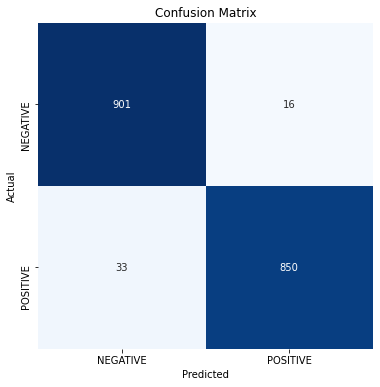

Classification Report:
--------------------------------------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.98      0.97       917
    POSITIVE       0.98      0.96      0.97       883

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [39]:
evaluate_model(model, test_data)